In [ ]:

import os
import glob


import rasterio
from rasterio.plot import show


import matplotlib.pyplot as plt
import seaborn as sns


import numpy as np


import tensorflow.python.keras as k
import tensorflow as tf
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.initializers import random_uniform, glorot_uniform
from tensorflow.keras.models import Model


import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, cmap='Blues'):
    cm = confusion_matrix(y_true, y_pred)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title = 'Normalized Confusion Matrix'
    else:
        title = 'Confusion Matrix'
    
    plt.figure(figsize=(len(classes)+2, len(classes)))
    sns.heatmap(cm, annot=True, fmt=".2f", cmap=cmap, cbar=False)
    plt.title(title)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.xticks(np.arange(len(classes))+0.5, classes, rotation=45)
    plt.yticks(np.arange(len(classes))+0.5, classes, rotation=0)
    plt.show()



In [ ]:
dataset_url = r'C:\Users\91989\OneDrive\Desktop\LAND_COVER_CLASSIFICATION\EuroSAT\2750'
batch_size = 32
img_height = 64
img_width = 64
validation_split=0.2
rescale=1.0/255


In [ ]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(validation_split=validation_split, rescale=rescale)
dataset = tf.keras.preprocessing.image_dataset_from_directory(dataset_url, image_size=(img_height, img_width), batch_size=batch_size)

Found 27000 files belonging to 10 classes.


In [ ]:
train_dataset = datagen.flow_from_directory(batch_size=batch_size,
                                           directory=dataset_url,
                                           shuffle=True,
                                           target_size=(img_height, img_width),
                                           subset="training",
                                           class_mode='categorical')

Found 21600 images belonging to 10 classes.


In [3]:
test_dataset = datagen.flow_from_directory(batch_size=batch_size,
                                           directory=dataset_url,
                                           shuffle=True,
                                           target_size=(img_height, img_width),
                                           subset="validation",
                                           class_mode='categorical')

Found 5400 images belonging to 10 classes.


In [ ]:
import tensorflow as tf

# Load saved model
model = tf.keras.models.load_model(
    r"C:\Users\91989\OneDrive\Desktop\LAND_COVER_CLASSIFICATION\lulc_2_epoch"
)

# Evaluate on the existing validation dataset
loss, acc = model.evaluate(test_dataset)
print(f"✅ Validation Accuracy: {acc * 100:.2f}%")
print(f"📉 Validation Loss: {loss:.4f}")


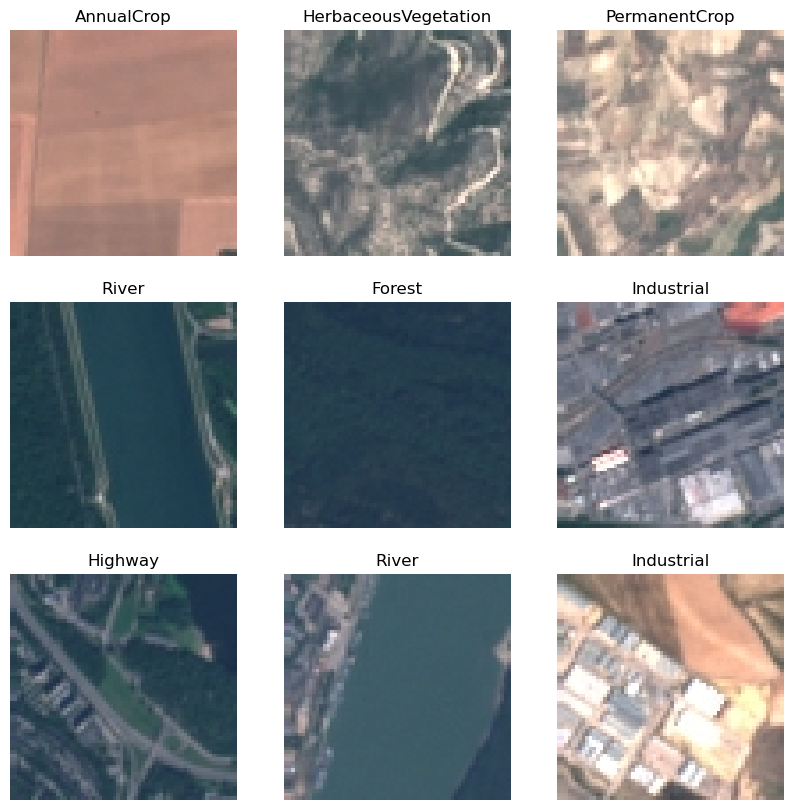

In [ ]:
class_names = dataset.class_names
plt.figure(figsize=(10, 10))
for images, labels in dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [ ]:
def identity_block(X, f, filters, training=True, initializer=random_uniform):
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value.
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(1, 1), padding='valid', kernel_initializer=initializer(seed=0))(X)
    X = BatchNormalization(axis=3)(X, training=training)
    X = Activation('relu')(X)
    
    # Second component of main path
    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', kernel_initializer=initializer(seed=0))(X)
    X = BatchNormalization(axis=3)(X, training=training)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', kernel_initializer=initializer(seed=0))(X)
    X = BatchNormalization(axis=3)(X, training=training)
    
    # Adjust shortcut path (add a 1x1 convolution if needed)
    X_shortcut = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', kernel_initializer=initializer(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3)(X_shortcut, training=training)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X_shortcut, X])
    X = Activation('relu')(X)

    return X


In [ ]:
def convolutional_block(X, f, filters, s=2, training=True, initializer=glorot_uniform):
   
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X

    ##### MAIN PATH #####
    
    # First component of main path glorot_uniform(seed=0)
    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(s, s), padding='valid', kernel_initializer=initializer(seed=0))(X)
    X = BatchNormalization(axis=3)(X, training=training)
    X = Activation('relu')(X)
    
    # Second component of main path (≈3 lines)
    X = Conv2D(F2, (f, f), strides=(1, 1), padding='same', kernel_initializer=initializer(seed=0))(X)
    X = BatchNormalization(axis=3)(X, training=training)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(F3, (1, 1), strides=(1, 1), padding='valid', kernel_initializer=initializer(seed=0))(X)
    X = BatchNormalization(axis=3)(X, training=training)

    ##### SHORTCUT PATH #### (Adjust the stride and add a 1x1 convolution if needed)
    X_shortcut = Conv2D(F3, (1, 1), strides=(s, s), padding='valid', kernel_initializer=initializer(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3)(X_shortcut, training=training)

    # If the strides are not equal, add a 1x1 convolution to the shortcut path
    if s != 1:
        X_shortcut = Conv2D(F3, (1, 1), strides=(1, 1), padding='valid', kernel_initializer=initializer(seed=0))(X_shortcut)
        X_shortcut = BatchNormalization(axis=3)(X_shortcut, training=training)

    # Final step: Add shortcut value to main path (Use this order [X, X_shortcut]), and pass it through a RELU activation
    X = Add()([X_shortcut, X])
    X = Activation('relu')(X)
    
    return X


In [ ]:
def ResNet50(input_shape=(64, 64, 3), classes=6):
  

    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)

    # Stage 1
    X = Conv2D(64, (7, 7), strides=(2, 2), kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f=3, filters=[64, 64, 256], s=1)
    X = identity_block(X, 3, [64, 64, 256])
    X = identity_block(X, 3, [64, 64, 256])

    # Stage 3
    X = convolutional_block(X, f=3, filters=[128, 128, 512], s=2)
    X = identity_block(X, 3, [128, 128, 512])
    X = identity_block(X, 3, [128, 128, 512])

    # Stage 4
    X = convolutional_block(X, f=3, filters=[256, 256, 1024], s=2)
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])

    # Stage 5
    X = convolutional_block(X, f=3, filters=[512, 512, 2048], s=2)
    X = identity_block(X, 3, [512, 512, 2048])
    X = identity_block(X, 3, [512, 512, 2048])

    # AVGPOOL
    X = AveragePooling2D(pool_size=(2, 2), name='avg_pool')(X)

    # Output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', kernel_initializer=glorot_uniform(seed=0))(X)

    # Create model
    model = Model(inputs=X_input, outputs=X)

    return model




In [ ]:
model = ResNet50(input_shape=(64, 64, 3), classes=10)

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping


early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


history = model.fit(train_dataset, validation_data=test_dataset, epochs=100, batch_size=32, callbacks=[early_stopping])


Epoch 1/100
675/675 [==============================] - 5828s 8s/step - loss: 1.4225 - accuracy: 0.5096 - val_loss: 1.1907 - val_accuracy: 0.5487
Epoch 2/100
675/675 [==============================] - 5340s 8s/step - loss: 1.0095 - accuracy: 0.6534 - val_loss: 1.1530 - val_accuracy: 0.5931
Epoch 3/100
675/675 [==============================] - 4966s 7s/step - loss: 0.8965 - accuracy: 0.6945 - val_loss: 0.9930 - val_accuracy: 0.6678
Epoch 4/100
675/675 [==============================] - 4861s 7s/step - loss: 0.9367 - accuracy: 0.6773 - val_loss: 0.9796 - val_accuracy: 0.6381
Epoch 5/100
675/675 [==============================] - 5426s 8s/step - loss: 0.8671 - accuracy: 0.7057 - val_loss: 0.8554 - val_accuracy: 0.7015
Epoch 6/100
675/675 [==============================] - 5326s 8s/step - loss: 0.7823 - accuracy: 0.7337 - val_loss: 0.8121 - val_accuracy: 0.7170
Epoch 7/100
675/675 [==============================] - 5078s 8s/step - loss: 0.8582 - accuracy: 0.7156 - val_loss: 0.7856 - val_ac

In [ ]:
model.save('lulc_2_epoch')

INFO:tensorflow:Assets written to: lulc_2_epoch\assets


INFO:tensorflow:Assets written to: lulc_2_epoch\assets


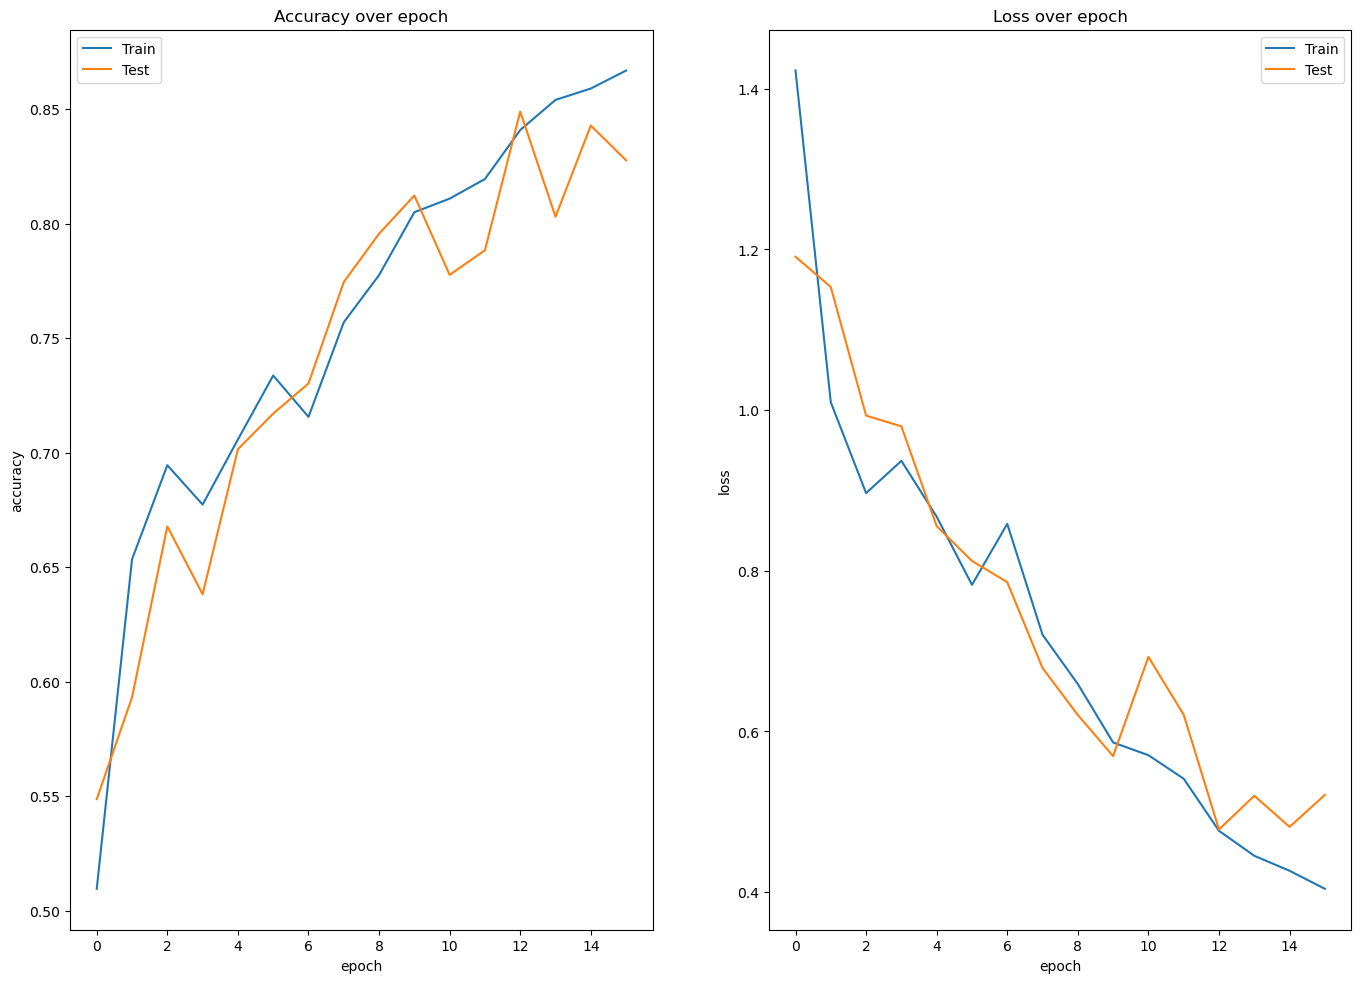

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16.53, 11.69))
ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.set_xlabel('epoch')
ax1.set_ylabel('accuracy')
ax1.set_title('Accuracy over epoch')
ax1.legend(['Train', 'Test'], loc='upper left')

ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_xlabel('epoch')
ax2.set_ylabel('loss')
ax2.set_title('Loss over epoch')
ax2.legend(['Train', 'Test'], loc="upper right")

In [ ]:
y_pred = []  
y_true = [] 

# iterate over the dataset
for i, (image_batch, label_batch) in enumerate(test_dataset):   # use dataset.unbatch() with repeat
    # append true labels
    y_true.append(label_batch)
    # compute predictions
    preds = model.predict(image_batch)
    # append predicted labels
    y_pred.append(np.argmax(preds, axis =  1))
    if i==300:
        break


correct_labels = tf.concat([item for item in y_true], axis = 0)
correct_labels = np.argmax(correct_labels, axis=1)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

1/1 [==============================] - 2s 2s/step


In [ ]:
cm = confusion_matrix(correct_labels, predicted_labels)
cm


array([[ 869,    7,   32,   42,    0,   20,   39,    1,   50,   10],
       [   1, 1013,   24,    1,    0,   13,    0,    0,    6,    8],
       [  11,   13,  888,   22,   31,    9,   60,   27,    4,    3],
       [  16,    0,   10,  702,   54,    3,   36,   21,   53,    0],
       [   0,    0,    2,   19,  749,    0,    2,   96,   17,    0],
       [  52,   18,   49,    1,    0,  541,   22,    0,   14,    3],
       [  58,    1,  112,   32,    5,   15,  655,   10,    8,    0],
       [   0,    0,    8,    1,   16,    0,    6, 1039,    4,    0],
       [  39,    5,   17,   96,   15,   33,   14,    3,  675,    4],
       [  25,   18,    3,    0,    0,    6,    0,    0,    8, 1009]],
      dtype=int64)

In [ ]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        figsize=(10, 10),
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[ 869    7   32   42    0   20   39    1   50   10]
 [   1 1013   24    1    0   13    0    0    6    8]
 [  11   13  888   22   31    9   60   27    4    3]
 [  16    0   10  702   54    3   36   21   53    0]
 [   0    0    2   19  749    0    2   96   17    0]
 [  52   18   49    1    0  541   22    0   14    3]
 [  58    1  112   32    5   15  655   10    8    0]
 [   0    0    8    1   16    0    6 1039    4    0]
 [  39    5   17   96   15   33   14    3  675    4]
 [  25   18    3    0    0    6    0    0    8 1009]]


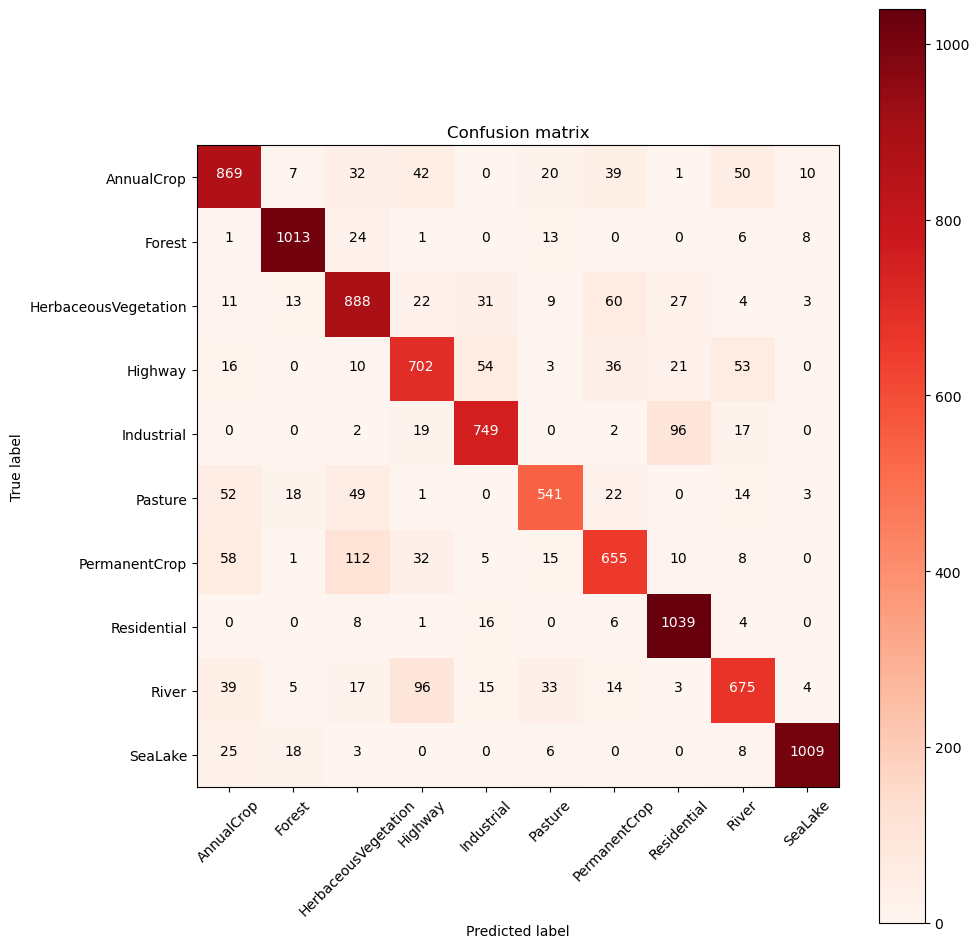

In [ ]:
plot_confusion_matrix(cm, train_dataset.class_indices, cmap='Reds')

In [ ]:
# Assuming class_labels is a list of class labels
for index, label in enumerate(class_labels):
    print(f"Class Index: {index}, Class Label: {label}")


Class Index: 0, Class Label: AnnualCrop
Class Index: 1, Class Label: Forest
Class Index: 2, Class Label: HerbaceousVegetation
Class Index: 3, Class Label: Highway
Class Index: 4, Class Label: Industrial
Class Index: 5, Class Label: Pasture
Class Index: 6, Class Label: PermanentCrop
Class Index: 7, Class Label: Residential
Class Index: 8, Class Label: River
Class Index: 9, Class Label: SeaLake
